In [45]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [46]:
rootfolder = '.'

Useful function for plot the 2D DCT dictionary

In [47]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [48]:
def OMP(s, D, L, tau):
  omega = set()
  r = s
  N = D.shape[1]
  while len(omega) < L or np.linalg.norm(r) > tau:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        e[j] = np.linalg.norm(D[:, j] @ r)

    # find the column of D that matches at best r
    jStar = np.argmax(e)

    # UPDATE the support set with the jStar coefficient
    omega.add(jStar)

    _omega = list(omega)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    x_OMP = np.linalg.inv(D[:, _omega].T @ D[:, _omega]) @ D[:, _omega].T @ s
    # update the residual
    r = s -  D[:, _omega] @ x_OMP

    x = np.zeros(N)
    x[list(omega)] = x_OMP.reshape(-1)

    return x


Load the image and rescale it in $[0,1]$

In [49]:
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [50]:
sigma_noise = 20/255
noisy_img = img + sigma_noise * np.random.randn(*img.shape)

Compute the psnr of the noisy input

In [51]:
psnr_noisy = 10 * np.log10(1 / np.mean((img - noisy_img) ** 2))


Text(0.5, 1.0, 'Noisy image, PSNR = 22.13')

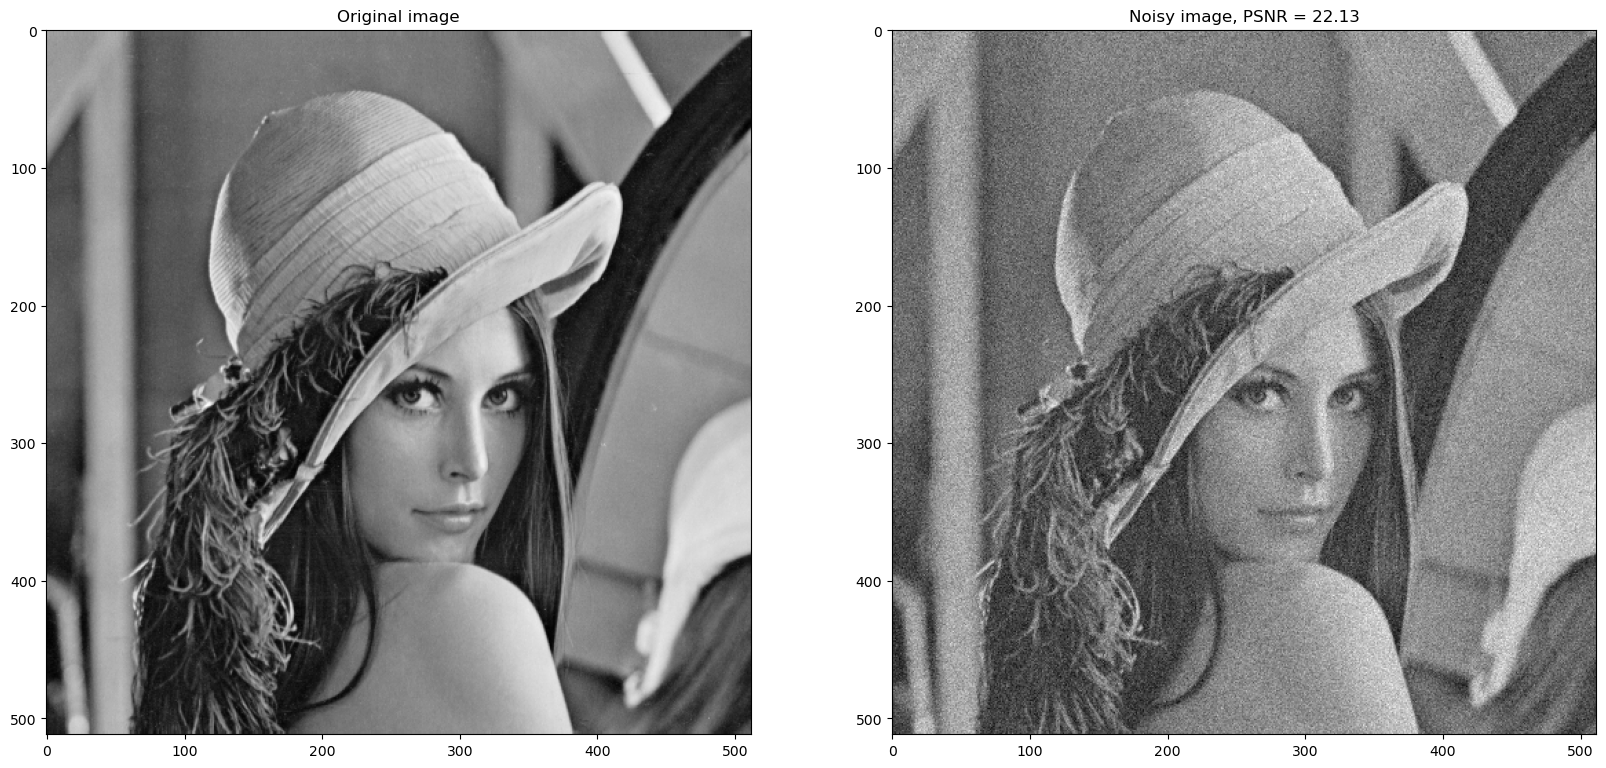

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Load and display the dictionary learned from patches

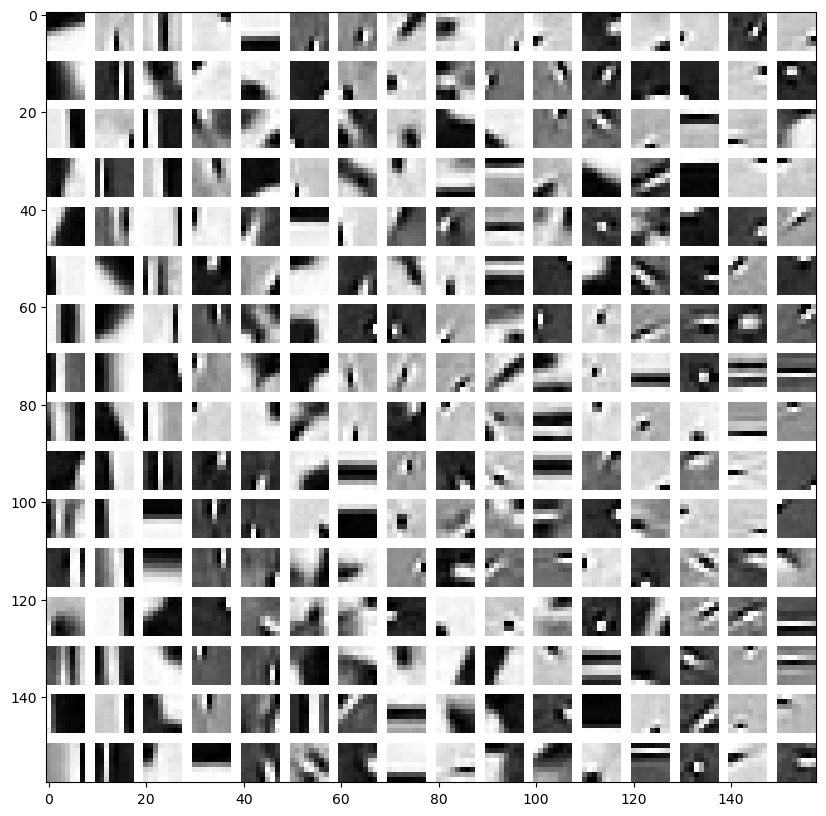

In [53]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# display the dct basis
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

Denoising
---------


In [62]:
# initialize the estimated image
img_hat = np.zeros(imsz)

# initialize the weight matrix
weights = np.zeros(imsz)

# set the threshold
tau = 1.15 * p * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 1 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [63]:
k = 0

for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):

        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p]

        s = s.reshape((64, 1))
        mean = np.mean(s)

        # store and subtract the mean

        # perform the sparse coding
        x = OMP(s, D, M, tau)

        # perform the reconstruction
        s_hat = np.matmul(D, x)


        s_hat += mean
        # add back the mean
        s_hat = s_hat.reshape((8, 8))

        # put the denoised patch into the estimated image using uniform weights
#        UPDATE img_hat
        img_hat[i:i+p, j:j+p] += s_hat

        # store the weight of the current patch in the weight matrix
#        UPDATE weights
        weights[i:i+p, j:j+p] += 1
        k += 1


Normalize the estimated image with the computed weights

In [64]:
img_hat = img_hat / weights

psnr_hat = 10 * np.log10(1 / np.mean((img - img_hat) ** 2))

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 30.72')

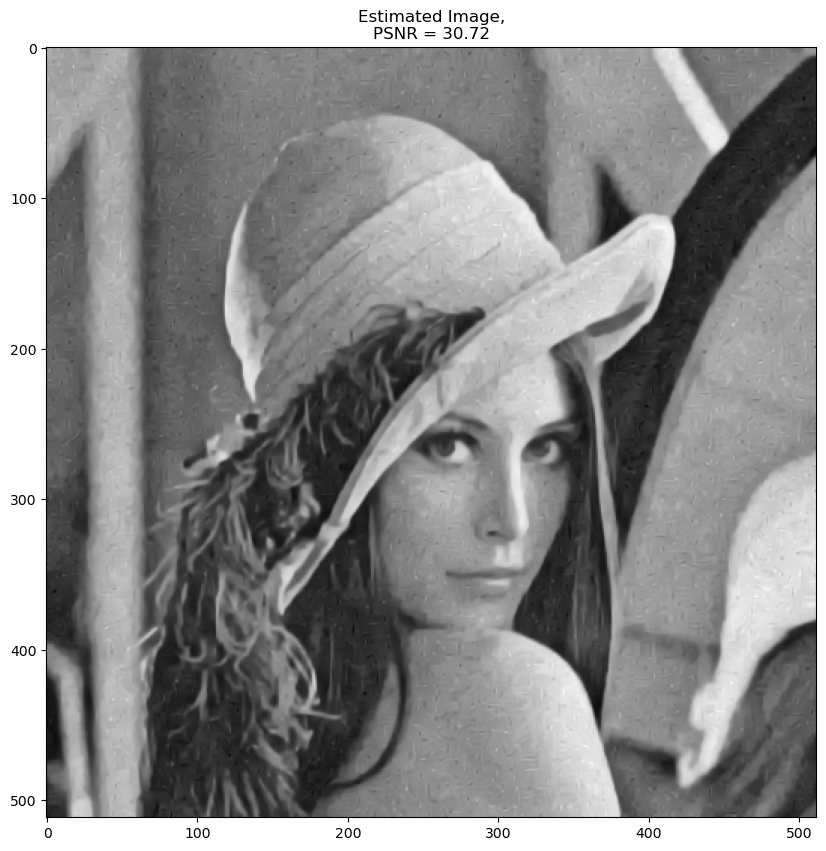

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
